# ATAC-seq analysis in R


In this tutorial, we go over how to use scvi-tools functionality in R for analyzing ATAC-seq data. We will closely follow the PBMC tutorial from [Signac](https://satijalab.org/signac/articles/pbmc_vignette.html), using scvi-tools when appropriate. In particular, we will 

1. Use PeakVI for dimensionality reduction and differential accessiblity for the ATAC-seq data
2. Use scVI to integrate the unpaired ATAC-seq dataset with a match scRNA-seq dataset of PBMCs

This tutorial requires Reticulate. Please check out our installation [guide](https://www.scvi-tools.org/en/latest/installation.html#scvi-tools-installation-for-R) for instructions on installing Reticulate and scvi-tools.

## Loading and processing data with Signac

In [1]:
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_singlecell.csv")
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_fragments.tsv.gz")
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_fragments.tsv.gz.tbi")

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)

Attaching SeuratObject

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: ensembldb

Loading required package: GenomicRanges

Loading required package: GenomicFeatures

Loading required p

## Pre-processing

We follow the original tutorial to create the Seurat object with ATAC data.

```{note}
For general pre-processing for various datatypes used by scvi-tools models, see the [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing.html#scatac-seq).
```

In [2]:
counts <- Read10X_h5(filename = "atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "atac_v1_pbmc_10k_singlecell.csv",
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg19',
  fragments = 'atac_v1_pbmc_10k_fragments.tsv.gz',
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


In [3]:
pbmc

An object of class Seurat 
87561 features across 8728 samples within 1 assay 
Active assay: peaks (87561 features, 0 variable features)

In [4]:
pbmc[['peaks']]

ChromatinAssay data with 87561 features for 8728 cells
Variable features: 0 
Genome: hg19 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

We add gene annotation information to facilitate downstream functionality.

In [5]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg19"

# add the gene information to the object
Annotation(pbmc) <- annotations

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

## Computing QC metrics

We compute the same QC metrics as the [original tutorial](https://satijalab.org/signac/articles/pbmc_vignette.html#computing-qc-metrics-1). We leave it to the reader to follow the excellent Signac tutorial for understanding what these quantities represent.

In [6]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc, fast = FALSE)

# add blacklist ratio and fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



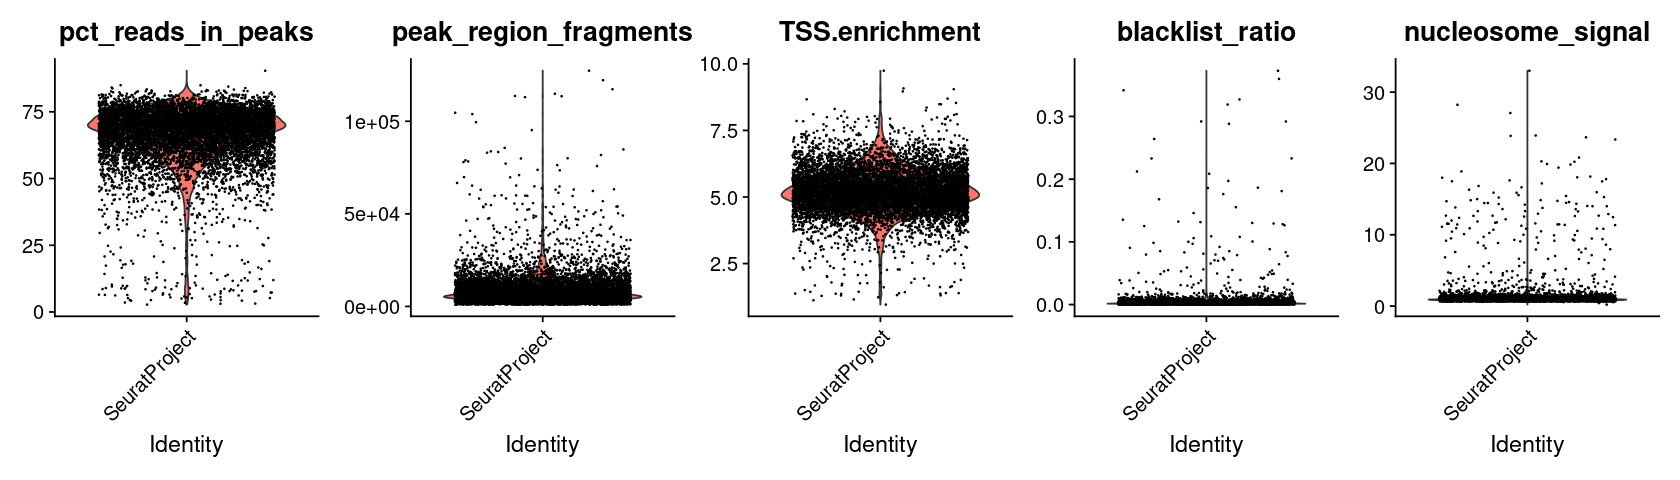

In [7]:
options(repr.plot.width=14, repr.plot.height=4)
VlnPlot(
  object = pbmc,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [8]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
pbmc

An object of class Seurat 
87561 features across 7060 samples within 1 assay 
Active assay: peaks (87561 features, 0 variable features)

## Dimensionality reduction (PeakVI)


### Creating an AnnData object

We follow the standard workflow for converting between Seurat and AnnData.

In [9]:
library(reticulate)
library(sceasy)
use_python("/home/adam/.pyenv/versions/3.9.7/bin/python", required = TRUE)
sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)

In [10]:
adata <- convertFormat(pbmc, from="seurat", to="anndata", main_layer="counts", assay="peaks", drop_single_values=FALSE)
print(adata) # Note generally in Python, dataset conventions are obs x var

AnnData object with n_obs × n_vars = 7060 × 87561
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio'
    var: 'count', 'percentile'


### Run the standard PeakVI workflow

In [11]:
scvi$model$PEAKVI$setup_anndata(adata)

None

In [12]:
pvi <- scvi$model$PEAKVI(adata)
pvi$train()

None

In [13]:
# get the latent represenation
latent = pvi$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(pbmc)
ndims <- ncol(latent)
pbmc[["peakvi"]] <- CreateDimReducObject(embeddings = latent, key = "peakvi_", assay = "peaks")

Warning message:
"No columnames present in cell embeddings, setting to 'peakvi_1:17'"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7060
Number of edges: 220834

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8544
Number of communities: 18
Elapsed time: 0 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
14:53:51 UMAP embedding parameters a = 0.9922 b = 1.112

14:53:51 Read 7060 rows and found 17 numeric columns

14:53:51 Using Annoy for neighbor search, n_neighbors = 30

14:53:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:53:52 Writing NN index file to temp file /tmp/RtmpIDkqBd/file41f83787c253

14:53:52 Searching Annoy index using 1 thread, search_k = 3000

14:53:53 Annoy recall = 100%

14:53:55 Commencing smooth kNN distance calibration using 1 thread

14:53:56 Initializing fro

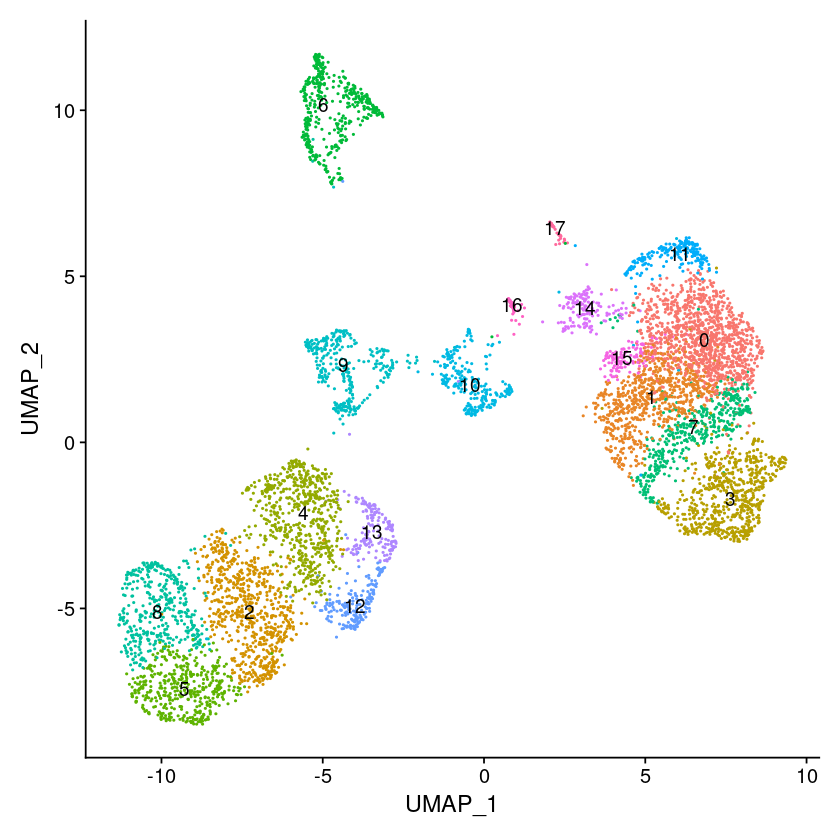

In [14]:
# Find clusters, then run UMAP, and visualize
pbmc <- FindNeighbors(pbmc, reduction = "peakvi", dims=1:ndims)
pbmc <- FindClusters(pbmc, resolution = 1)

pbmc <- RunUMAP(pbmc, reduction = "peakvi", dims=1:ndims)

options(repr.plot.width=7, repr.plot.height=7)
DimPlot(object = pbmc, label = TRUE) + NoLegend()

## Create a gene activity matrix

```{important}
The gene activity is used as an approximation of a gene expression matrix such that unpaired ATAC data can be integrated with RNA data. We recommend using this approach only for this unpaired case. Better results can be acheived if there is partially paired data, in which case MultiVI can be used.
```

In [15]:
gene.activities <- GeneActivity(pbmc)

# add the gene activity matrix to the Seurat object as a new assay and normalize it
pbmc[['RNA']] <- CreateAssayObject(counts = gene.activities)
pbmc <- NormalizeData(
  object = pbmc,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(pbmc$nCount_RNA)
)

Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"


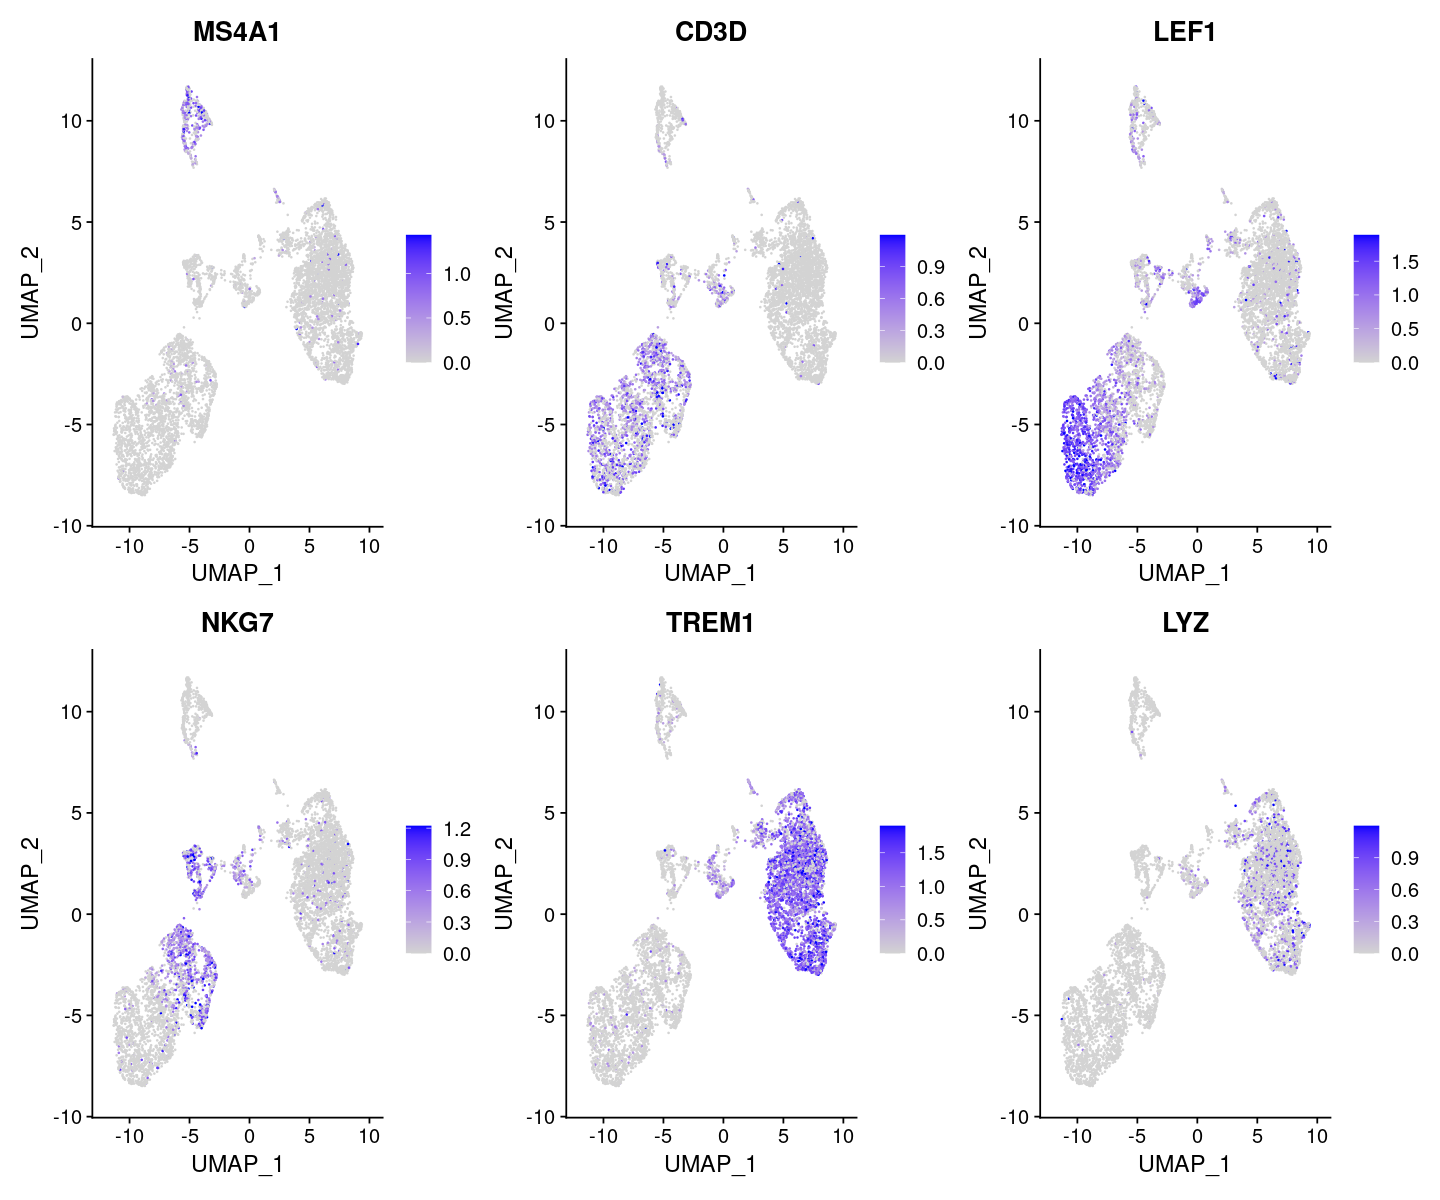

In [16]:
options(repr.plot.width=12, repr.plot.height=10)

DefaultAssay(pbmc) <- 'RNA'

FeaturePlot(
  object = pbmc,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

## Integrating with scRNA-seq data (scANVI)

We can integrate the gene activity matrix with annotated scRNA-seq data using scANVI.

First we download the Seurat-processed PBMC 10k dataset (as in their tutorial). 

In [23]:
system("wget https://www.dropbox.com/s/zn6khirjafoyyxl/pbmc_10k_v3.rds?dl=1 -O pbmc_10k_v3.rds")

In [17]:
pbmc_rna <- readRDS("pbmc_10k_v3.rds")

And we convert it to AnnData using sceasy again. Subsequently, we follow the standard scANVI workflow: pretraining with scVI then running scANVI.

In [18]:
adata_rna <- convertFormat(pbmc_rna, from="seurat", to="anndata", main_layer="counts", assay="RNA", drop_single_values=FALSE)
adata_atac_act <- convertFormat(pbmc, from="seurat", to="anndata", main_layer="counts", assay="RNA", drop_single_values=FALSE)

# provide adata_atac_act unknown cell type labels
adata_atac_act$obs$insert(adata_atac_act$obs$shape[1], "celltype", "Unknown")

adata_both <- adata_rna$concatenate(adata_atac_act)

None

We concatenated the RNA expression with the activity matrix using AnnData. Now we can see the last column is called "batch" and denotes which dataset each cell originated from.

In [19]:
head(py_to_r(adata_both$obs))

,orig.ident,nCount_RNA,nFeature_RNA,observed,simulated,percent.mito,RNA_snn_res.0.4,celltype,nCount_peaks,nFeature_peaks,⋯,peak_region_fragments,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,pct_reads_in_peaks,blacklist_ratio,peaks_snn_res.1,seurat_clusters,batch
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
rna_AAACCCAAGCGCCCAT-1-0,10x_RNA,2204,1087,0.035812672,0.4382022,0.02359347,1,CD4 Memory,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,0
rna_AAACCCACAGAGTTGG-1-0,10x_RNA,5884,1836,0.019227034,0.1017964,0.10757988,0,CD14+ Monocytes,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,0
rna_AAACCCACAGGTATGG-1-0,10x_RNA,5530,2216,0.005447865,0.1392801,0.07848101,5,NK dim,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,0
rna_AAACCCACATAGTCAC-1-0,10x_RNA,5106,1615,0.014276003,0.4949495,0.10830396,3,pre-B cell,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,0
rna_AAACCCACATCCAATG-1-0,10x_RNA,4572,1800,0.053857351,0.1392801,0.08989501,5,NK bright,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,0
rna_AAACCCAGTGGCTACC-1-0,10x_RNA,6702,1965,0.056603774,0.3554328,0.06326470,1,CD4 Memory,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,0


In [20]:
sc$pp$highly_variable_genes(
    adata_both, 
    flavor="seurat_v3", 
    n_top_genes=r_to_py(3000), 
    batch_key="batch", 
    subset=TRUE
)
scvi$model$SCVI$setup_anndata(adata_both, labels_key="celltype", batch_key="batch")

None

None

In [21]:
model <- scvi$model$SCVI(adata_both, gene_likelihood="nb", dispersion="gene-batch")
model$train()

None

In [22]:
lvae <- scvi$model$SCANVI$from_scvi_model(model, "Unknown", adata=adata_both)
lvae$train(max_epochs = as.integer(100), n_samples_per_label = as.integer(100))

None

Here we only use the prediction functionality of scANVI, but we also could have viewed an integrated representation of the ATAC and RNA using UMAP. 

In [23]:
adata_both$obs$insert(adata_both$obs$shape[1], "predicted.labels", lvae$predict())
df <- py_to_r(adata_both$obs)
df <- subset(df, batch == 1)[, c("predicted.labels")]
pbmc <- AddMetaData(object = pbmc, metadata = df, col.name="predicted.labels")

None

```{important}
These labels should only serve as a starting point. Further inspection should always be performed. We leave this to the user, but will continue with these labels as a demonstration.
```

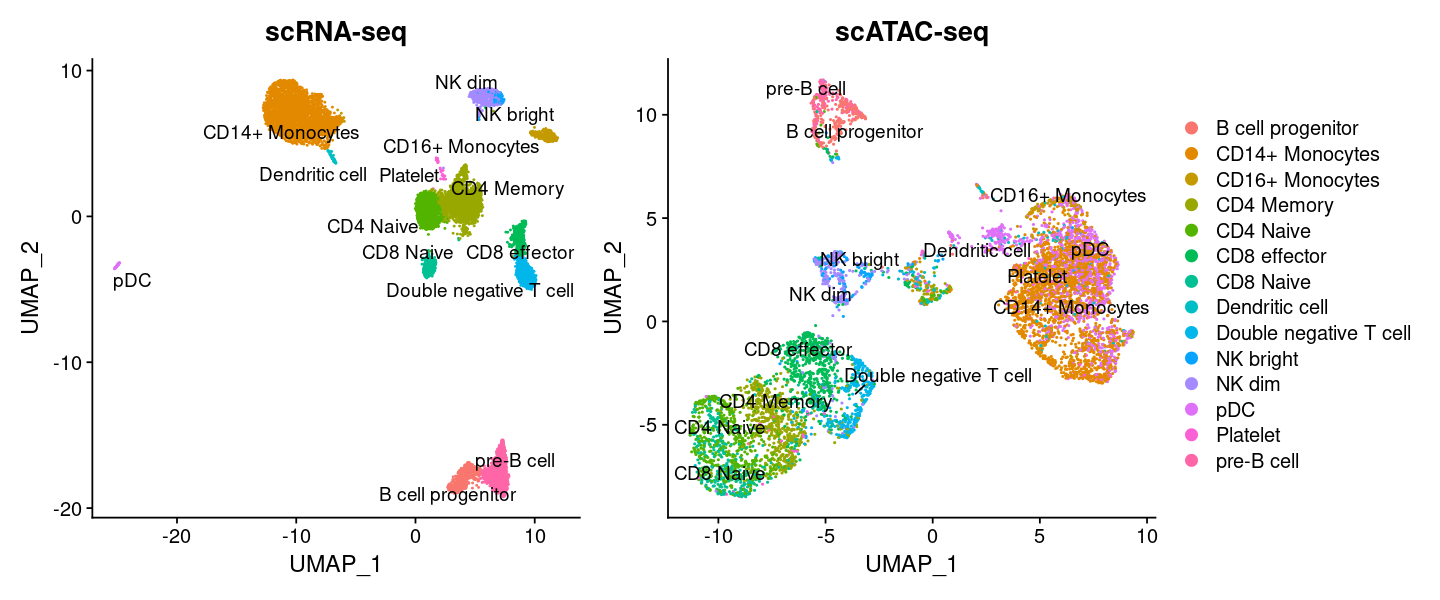

In [24]:
options(repr.plot.width=12, repr.plot.height=5)

plot1 <- DimPlot(
  object = pbmc_rna,
  group.by = 'celltype',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot2 <- DimPlot(
  object = pbmc,
  group.by = 'predicted.labels',
  label = TRUE,
  repel = TRUE) + ggtitle('scATAC-seq')

plot1 + plot2

## Finding differentially accessible peaks between clusters

As PeakVI learns uncertainty around the observed data, it can be leveraged for differential accessibility analysis. First, let's store the seurat cluster information back inside the AnnData.

In [25]:
adata$obs$insert(adata$obs$shape[1], "predicted_ct", pbmc[["predicted.labels"]][,1])

None

Using our trained PEAKVI model, we call the `differential_accessibility()` (DA) method
We pass `predicted_ct` to the groupby argument and compare between naive CD4s and CD14 monocytes.

The output of DA is a DataFrame with the bayes factors. Bayes factors > 3 have high probability of being differentially expressed. You can also set fdr_target, which will return the differentially expressed genes based on the posteior expected FDR. 

In [26]:
DA <- pvi$differential_accessibility(adata, groupby="predicted_ct", group1 = "CD4 Naive", group2 = "CD14+ Monocytes")
DA <- py_to_r(DA)
head(DA)

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1-565107-565550,0.0738,FALSE,-2.5297313,-0.02128995,-0.009461094,0.03177977,0.010489821,0.014539580,0.005078486
chr1-569174-569639,0.5342,FALSE,0.1370139,-0.06247292,-0.026307585,0.08119156,0.018718639,0.035541195,0.009233610
chr1-713460-714823,0.9208,TRUE,2.4532664,-0.27283466,-0.164037549,0.73534369,0.462509036,0.389337641,0.225300092
chr1-752422-753038,0.9722,TRUE,3.5545252,0.18390924,0.093491423,0.01899158,0.202900812,0.004846527,0.098337950
chr1-762106-763359,0.8202,FALSE,1.5177030,-0.15394741,-0.096660536,0.51465970,0.360712290,0.266558966,0.169898430
chr1-779589-780271,0.7834,FALSE,1.2855911,-0.09098869,-0.049387882,0.09661592,0.005627228,0.051696284,0.002308403


In [27]:
# sort by proba_da and effect_size
DA <- DA[order(-DA[, 1], -DA[, 4]), ]
head(DA)

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17-1510080-1511616,1.0000,TRUE,18.420681,0.8669005,0.4471439,0.04267091,0.90957141,0.027463651,0.474607572
chr8-141108218-141111251,1.0000,TRUE,18.420681,-0.8540915,-0.4437980,0.89332950,0.03923802,0.466882068,0.023084026
chr14-50504661-50507777,0.9998,TRUE,8.516943,0.8495569,0.5436486,0.14001995,0.98957688,0.085621971,0.629270545
chr19-36397851-36401040,0.9998,TRUE,8.516943,0.8030195,0.3956684,0.07268646,0.87570596,0.035541195,0.431209603
chr7-6674416-6675306,0.9998,TRUE,8.516943,0.4002175,0.1814427,0.01607980,0.41629726,0.009693053,0.191135734
chr1-23945628-23947309,0.9998,TRUE,8.516943,-0.7074655,-0.3593336,0.72208506,0.01461957,0.366720517,0.007386888


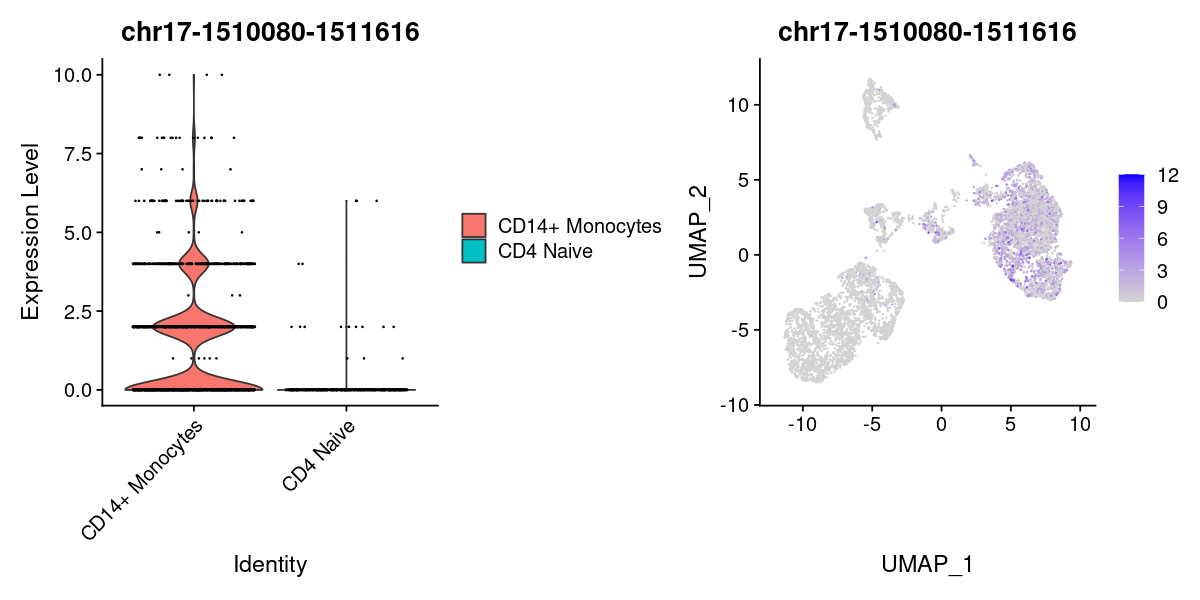

In [28]:
options(repr.plot.width=10, repr.plot.height=5)

DefaultAssay(pbmc) <- 'peaks'
Idents(pbmc) <- pbmc[["predicted.labels"]]

plot1 <- VlnPlot(
  object = pbmc,
  features = rownames(DA)[1],
  pt.size = 0.1,
  idents = c("CD4 Naive","CD14+ Monocytes")
)
plot2 <- FeaturePlot(
  object = pbmc,
  features = rownames(DA)[1],
  pt.size = 0.1
)

plot1 | plot2

In [29]:
sI <- sessionInfo()
sI$loadedOnly <- NULL
print(sI, locale=FALSE)

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] sceasy_0.0.6              reticulate_1.20          
 [3] patchwork_1.1.1           ggplot2_3.3.5            
 [5] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.17.4         
 [7] AnnotationFilter_1.17.1   GenomicFeatures_1.45.2   
 [9] AnnotationDbi_1.55.1      Biobase_2.53.0           
[11] GenomicRanges_1.45.0      GenomeInfoDb_1.29.8      
[13] IRanges_2.27.2            S4Vectors_0.31.3         
[15] BiocGenerics_0.39.2       SeuratObject_4.0.2       
[17] Seurat_4.0.4              Signac_1.3.0             
